# Biophysical Neural Network to predict the intial region of tau prapagtion 

In [44]:
# All imports needed to run the model and process the data
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns




### Import the Data

In [45]:
# Import the Demographics data 
demographics = pd.read_csv("data/Merged_Tau_with_Demographics_and_Seeds.csv")

In [46]:
# Import connectome and Drop unaamed column
connectome = pd.read_csv("data/connectome_mean80_fibercount_ordered.csv")
connectome.drop(columns=["Unnamed: 0"], inplace=True)



### Features 

In [47]:
# Extract the seed regions from the demographics data
seed_columns = filter(lambda x: x.endswith('_seed'), demographics.columns)
seed_regions = list(seed_columns)
len(seed_regions)


78

In [48]:
# Extract the actual tau regions from the demographics data
twd_columns = filter(lambda x: x.endswith('_demographics'), demographics.columns)
twd_regions = list(twd_columns)
len(twd_regions)

78

In [49]:
# all the regions of tau concentration per patients 
tau_all = demographics[twd_regions]


In [50]:
# all the regions of seed regions per patients
seed_all = demographics[seed_regions]

#### Dataframe to view the region Index


In [51]:
# Create a new DataFrame to store column names
seed_names_binary = pd.DataFrame(columns=['column_names of regions'])
seed_names_binary['column_names of regions'] = connectome.columns


In [52]:
#  Display the all of the rows of the DataFrame
pd.set_option('display.max_rows', None)
seed_names_binary


,column_names of regions
0,Left-Amygdala
1,Left-Cerebellum-Cortex
2,Left-Hippocampus
3,Left-Thalamus-Proper
4,Left-VentralDC
5,Right-Amygdala
6,Right-Cerebellum-Cortex
7,Right-Hippocampus
8,Right-Thalamus-Proper
9,Right-VentralDC


In [53]:
# Creating a dictionary where keys are DataFrame indices and values are column names
dictionary_regions = {i: row['column_names of regions'] for i, row in seed_names_binary.iterrows()}

print(dictionary_regions)

{0: 'Left-Amygdala', 1: 'Left-Cerebellum-Cortex', 2: 'Left-Hippocampus', 3: 'Left-Thalamus-Proper', 4: 'Left-VentralDC', 5: 'Right-Amygdala', 6: 'Right-Cerebellum-Cortex', 7: 'Right-Hippocampus', 8: 'Right-Thalamus-Proper', 9: 'Right-VentralDC', 10: 'ctx-lh-bankssts', 11: 'ctx-lh-caudalanteriorcingulate', 12: 'ctx-lh-caudalmiddlefrontal', 13: 'ctx-lh-cuneus', 14: 'ctx-lh-entorhinal', 15: 'ctx-lh-frontalpole', 16: 'ctx-lh-fusiform', 17: 'ctx-lh-inferiorparietal', 18: 'ctx-lh-inferiortemporal', 19: 'ctx-lh-insula', 20: 'ctx-lh-isthmuscingulate', 21: 'ctx-lh-lateraloccipital', 22: 'ctx-lh-lateralorbitofrontal', 23: 'ctx-lh-lingual', 24: 'ctx-lh-medialorbitofrontal', 25: 'ctx-lh-middletemporal', 26: 'ctx-lh-paracentral', 27: 'ctx-lh-parahippocampal', 28: 'ctx-lh-parsopercularis', 29: 'ctx-lh-parsorbitalis', 30: 'ctx-lh-parstriangularis', 31: 'ctx-lh-pericalcarine', 32: 'ctx-lh-postcentral', 33: 'ctx-lh-posteriorcingulate', 34: 'ctx-lh-precentral', 35: 'ctx-lh-precuneus', 36: 'ctx-lh-rostra

### Train/Test split

In [54]:
# Make all regions to numpy array
tau_all = tau_all.to_numpy()
seed_all = seed_all.to_numpy()
time = demographics["ml_stage"].to_numpy()


In [55]:
# Split the data into training and testing sets, including tau concentrations and time
X_train, X_test, y_train_tau, y_test_tau, y_train_time, y_test_time = train_test_split(
    tau_all, seed_all, time, test_size=0.2, random_state=42
)

## Model 

In [56]:
class TauDNN(nn.Module):
    """
    A Deep Neural Network (DNN) designed to predict the initial seeding and propagation of tau protein in the brain,
    based on patient tau demographics and machine learning (ML) stage. This network uses multiple layers of neurons
    (fully connected) to predict regions of tau propagation and associated timing of progression.

    Attributes:
        fc1 (nn.Linear): First fully connected layer, transforming input features into a hidden representation.
        relu1 (nn.ReLU): Non-linear activation function applied after the first layer.
        fc2 (nn.Linear): Second fully connected layer, further transforming the representation.
        relu2 (nn.ReLU): Non-linear activation function applied after the second layer.
        fc3 (nn.Linear): Third fully connected layer, creating a deeper representation of the input data.
        relu3 (nn.ReLU): Non-linear activation function applied after the third layer.
        fc4_tau (nn.Linear): Output layer for predicting tau concentration levels.
        fc4_time (nn.Linear): Output layer for predicting the time stages of tau progression.

    Methods:
        forward(x): Defines the computation performed at every call of the network.
    """
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim_tau, output_dim_time):
        """
        Initializes the TauDNN model with dynamic dimensions for the hidden layers and outputs.
        
        Parameters:
            input_dim (int): The dimensionality of the input feature vector.
            hidden1_dim (int): The number of neurons in the first hidden layer.
            hidden2_dim (int): The number of neurons in the second hidden layer.
            hidden3_dim (int): The number of neurons in the third hidden layer.
            output_dim_tau (int): The number of output features for tau concentration.
            output_dim_time (int): The output feature for time prediction.
        """
        super(TauDNN, self).__init__()
        # Define the network structure
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4_tau = nn.Linear(hidden3_dim, output_dim_tau)  # Output layer for tau concentration
        self.fc4_time = nn.Linear(hidden3_dim, output_dim_time)  # Output layer for time prediction
    def forward(self, x):
        """
        Perform a forward pass of the model on input data x.
        
        Parameters:
            x (Tensor): A tensor containing input data with dimensions [batch_size, input_dim]
        
        Returns:
            tuple: A tuple containing two tensors with tau concentrations and time predictions.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        tau_concentration = torch.relu(self.fc4_tau(x))  # Predicted tau concentration
        time_prediction = torch.relu(self.fc4_time(x))  # Predicted time
        return tau_concentration, time_prediction

### Input Parameters for the Model 

In [57]:
# Input parameters for the model
input_dim = X_train.shape[1]
output_dim_tau = connectome.shape[0]
output_dim_time = 1
hidden1_dim = 256
hidden2_dim = 128
hidden3_dim = 64


### Class with Model Utilities

In [58]:
# Define model utilities
class ModelUtilities:
    """
    A collection of utility methods for training and evaluating neural network models.

    Methods:
        train_model(model, train_loader, criterion, optimizer, device): Train a neural network model.
        evaluate_model(model, test_loader, device): Evaluate a neural network model.
        dice_score(predictions, targets): Compute the Dice score for two sets of data.
        calculate_loss(model, predictions_tau, predictions_time, targets_tau, targets_time, l1_weight, apply_regularization): Calculate the combined MSE loss for tau and time predictions.
    """
    @staticmethod
    def dice_score(predictions, targets):
        """
        Compute the Dice score, a measure of similarity between two sets of data.
        
        Parameters:
            predictions (Tensor): Predicted values.
            targets (Tensor): True values.
        
        Returns:
            float: The Dice score.
        """
        # Convert predictions and targets to binary by thresholding at zero
        predictions = (predictions > 0).float()
        targets = (targets > 0).float()
        # Calculate intersection and union of the predictions and targets
        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum()
        # Compute Dice score using the formula: 2 * intersection / (sum of elements in both sets)
        dice = (2. * intersection + 1e-8) / (union + 1e-8)
        return dice

    @staticmethod
    def calculate_loss(model, predictions_tau, predictions_time, targets_tau, targets_time, l1_weight, apply_regularization=False):
        """
        Calculate the combined MSE loss for tau and time predictions, optionally including L1 regularization.
        
        Parameters:
            model (nn.Module): The neural network model.
            predictions_tau (Tensor): Predictions for tau concentrations.
            predictions_time (Tensor): Predictions for time.
            targets_tau (Tensor): True tau concentrations.
            targets_time (Tensor): True times.
            l1_weight (float): The weight for L1 regularization.
            apply_regularization (bool): Whether to apply L1 regularization.
        
        Returns:
            Tensor: The total loss as a tensor.
        """
        # Ensure predictions_time and targets_time have the same number of dimensions
        if predictions_time.dim() > targets_time.dim():
            targets_time = targets_time.unsqueeze(1)  
        elif predictions_time.dim() < targets_time.dim():
            targets_time = targets_time.squeeze(1)  # Squeeze the dimension to match the predicted tensor
        # Calculate mean squared error (MSE) loss for tau and time predictions
        loss_tau = F.mse_loss(predictions_tau, targets_tau)
        loss_time = F.mse_loss(predictions_time, targets_time)
        total_mse_loss = loss_tau + loss_time
        # Add L1 regularization to the loss if specified
        if apply_regularization:
            # Compute L1 penalty (sum of absolute values of parameters)
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            total_loss = total_mse_loss + l1_weight * l1_penalty
        else:
            total_loss = total_mse_loss

        return total_loss

### Trainer class

In [59]:
class Trainer:
    """
    A class to handle the training and testing of the neural network model.
    
    This class manages the training process, including running epochs and storing training results.
    
    Attributes:
        model (nn.Module): The neural network model.
        epochs (int): The number of training epochs.
        batch_size (int): The size of each batch during training.
        l1_weight (float): The L1 regularization weight.
        optimizer (Optimizer): The optimizer for training the model.
    
    Methods:
        run_epoch(data_loader, training=True): Run a training or validation epoch.
        train(train_loader, val_loader): Conduct the training process over all epochs.
        test(test_loader): Evaluate the model on a test dataset.
    """
    def __init__(self, model, optimizer_type='adam', learning_rate=0.001, epochs=100, batch_size=32, l1_weight=0.0001):
        """
        Initialize the Trainer with a model, optimizer settings, and training parameters.
        
        Parameters:
            model (nn.Module): The neural network model to be trained.
            optimizer_type (str): The type of optimizer ('adam' or 'sgd').
            learning_rate (float): The learning rate for the optimizer.
            epochs (int): The total number of epochs to train.
            batch_size (int): The batch size used during training.
            l1_weight (float): The L1 regularization weight.
        """

        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.l1_weight = l1_weight
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) if optimizer_type == 'adam' else torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        self.utilities = ModelUtilities()

    def run_epoch(self, data_loader, training=True):
        """
        Executes training epochs of training or validation, depending on the mode specified.
        
        This method processes each batch of data, computes the loss, updates the model's weights during training,
        and calculates performance metrics for the epoch.

        Parameters:
            data_loader (DataLoader): The DataLoader object providing batched data for training or validation.
            training (bool, optional): Specifies whether the epoch is for training or validation. Default is True.

        Returns:
            dict: A dictionary containing average loss, dice scores for tau and time, and correlation coefficients for tau and time.
        """
        # Initialize lists to store loss and performance metrics
        losses = []
        dice_taus = []
        dice_times = []
        corrs_tau = []
        corrs_time = []
        
        for x_batch, y_batch_tau, y_batch_time in data_loader:
            if training:
                self.optimizer.zero_grad()

            predicted_tau, predicted_time = self.model(x_batch)
            loss = self.utilities.calculate_loss(self.model, predicted_tau, predicted_time, y_batch_tau, y_batch_time, self.l1_weight, apply_regularization=training)
            if training:
                loss.backward()
                self.optimizer.step()
            # Append loss and performance metrics to lists
            losses.append(loss.item())
            dice_taus.append(self.utilities.dice_score(predicted_tau, y_batch_tau).item())
            dice_times.append(self.utilities.dice_score(predicted_time.squeeze(), y_batch_time.squeeze()).item())
            corrs_tau.append(np.corrcoef(predicted_tau.detach().numpy().flatten(), y_batch_tau.detach().numpy().flatten())[0, 1])
            corrs_time.append(np.corrcoef(predicted_time.detach().numpy().flatten(), y_batch_time.detach().numpy().flatten())[0, 1])

        return {
            'loss': np.mean(losses),
            'dice_tau': np.mean(dice_taus),
            'dice_time': np.mean(dice_times),
            'corr_tau': np.mean(corrs_tau),
            'corr_time': np.mean(corrs_time)
        }

    def train(self, train_loader, val_loader):
        """
        Conducts the training process over a specified number of epochs, alternating between training and validation phases.

        This method iterates over all epochs, calling `run_epoch` for both training and validation data loaders.
        It collects and logs performance metrics for each epoch and provides visual feedback on the training process.

        Parameters:
            train_loader (DataLoader): The DataLoader for training data.
            val_loader (DataLoader): The DataLoader for validation data.

        Returns:
            dict: A dictionary containing lists of losses, dice scores, and correlation coefficients for both training and validation phases across all epochs.
        """
        # Initialize dictionary to store results for all epochs
        all_epoch_results = {
            'train_losses': [],
            'val_losses': [],
            'train_dice_tau': [],
            'val_dice_tau': [],
            'train_dice_time': [],
            'val_dice_time': [],
            'train_corrs_tau': [],
            'val_corrs_tau': [],
            'train_corrs_time': [],
            'val_corrs_time': []
        }

        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            train_results = self.run_epoch(train_loader, training=True)
            self.model.eval()
            with torch.no_grad():
                val_results = self.run_epoch(val_loader, training=False)

            all_epoch_results['train_losses'].append(train_results['loss'])
            all_epoch_results['val_losses'].append(val_results['loss'])
            all_epoch_results['train_dice_tau'].append(train_results['dice_tau'])
            all_epoch_results['val_dice_tau'].append(val_results['dice_tau'])
            all_epoch_results['train_dice_time'].append(train_results['dice_time'])
            all_epoch_results['val_dice_time'].append(val_results['dice_time'])
            all_epoch_results['train_corrs_tau'].append(train_results['corr_tau'])
            all_epoch_results['val_corrs_tau'].append(val_results['corr_tau'])
            all_epoch_results['train_corrs_time'].append(train_results['corr_time'])
            all_epoch_results['val_corrs_time'].append(val_results['corr_time'])

            if (epoch + 1) % 100 == 99:  # Print every 100 epochs
                print(f'Epoch {epoch + 1}: Train Loss: {train_results["loss"]}, Val Loss: {val_results["loss"]}, Train Dice Tau: {train_results["dice_tau"]}, Val Dice Tau: {val_results["dice_tau"]}, Train Dice Time: {train_results["dice_time"]}, Val Dice Time: {val_results["dice_time"]}, Train Corr Tau: {train_results["corr_tau"]}, Val Corr Tau: {val_results["corr_tau"]}, Train Corr Time: {train_results["corr_time"]}, Val Corr Time: {val_results["corr_time"]}')

        return all_epoch_results, train_results, val_results  # Return collected results for all epochs

    def test(self, test_loader):
        """
        Evaluates the trained model on a separate test dataset.

        This method runs a single epoch in evaluation mode (no backpropagation) using the provided test data loader,
        calculating loss and performance metrics to assess the model's generalization ability.

        Parameters:
            test_loader (DataLoader): The DataLoader containing test data.

        Returns:
            dict: A dictionary containing the test loss, dice scores for tau and time, and correlation coefficients for tau and time.
        """
        for epoch in tqdm(range(self.epochs)):
            self.model.eval()
            with torch.no_grad():
                test_results = self.run_epoch(test_loader, training=False)
            if (epoch + 1) % 100 == 99:  # Print every 100 epochs    
                print(f'Epoch {epoch + 1}: Test Loss: {test_results["loss"]}, Test Dice Tau: {test_results["dice_tau"]}, Test Dice Time: {test_results["dice_time"]}, Test Corr Tau: {test_results["corr_tau"]}, Test Corr Time: {test_results["corr_time"]}')
        return test_results


### Cross Validator class with K-fold

In [60]:
class CrossValidator:
    """
    Handles the cross-validation process for a given model and dataset.
    
    This class manages splitting the data into training and validation sets, executing the training, and aggregating the results across folds.

    Attributes:
        model_class (class): The class of the model to be trained.
        trainer_class (class): The class of the trainer to be used for training the model.
        Xs (np.array): Input features for the model.
        ys_tau (np.array): Target tau concentrations.
        ys_time (np.array): Target time values.
        test_Xs (np.array): Test dataset input features.
        test_ys_tau (np.array): Test dataset target tau concentrations.
        test_ys_time (np.array): Test dataset target time values.
        k (int): The number of folds for cross-validation.
        input_dim (int): The number of input dimensions for the model.
        hidden1_dim (int): The number of neurons in the first hidden layer.
        hidden2_dim (int): The number of neurons in the second hidden layer.
        hidden3_dim (int): The number of neurons in the third hidden layer.
        output_dim_tau (int): The number of tau output dimensions.
        output_dim_time (int): The number of time output dimensions.
        epochs (int): The number of epochs for training.
        batch_size (int): The batch size used during training.
        optimizer_type (str): The type of optimizer to use ('adam' or 'sgd').
        learning_rate (float): The learning rate for the optimizer.
        l1_weight (float): The L1 regularization weight.
    
    Methods:
        execute(): Executes the cross-validation process.
        plot_results(results, fold_index): Plots the training and validation results for a given fold.
        summarize_results(results, test=False): Prints a summary of results across all folds.
    """
    def __init__(self, model_class, trainer_class, Xs, ys_tau, ys_time, test_Xs, test_ys_tau, test_ys_time, k, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim_tau, output_dim_time, epochs=100, batch_size=32, optimizer_type='adam', learning_rate=1e-3, l1_weight=0.001):
        """
        Initializes the CrossValidator with the model class, trainer class, datasets, and training configurations.
        
        Parameters:
            model_class (class): The class of the model to be instantiated and trained.
            trainer_class (class): The class responsible for training the model.
            Xs (np.array): The feature set for cross-validation.
            ys_tau (np.array): The target tau concentrations for cross-validation.
            ys_time (np.array): The target times for cross-validation.
            test_Xs (np.array): The feature set for testing.
            test_ys_tau (np.array): The target tau concentrations for testing.
            test_ys_time (np.array): The target times for testing.
            k (int): Number of folds in K-fold cross-validation.
            input_dim (int): Dimensionality of input features.
            hidden1_dim (int): Number of neurons in the first hidden layer.
            hidden2_dim (int): Number of neurons in the second hidden layer.
            hidden3_dim (int): Number of neurons in the third hidden layer.
            output_dim_tau (int): Number of output features for tau concentration.
            output_dim_time (int): Number of output features for time prediction.
            epochs (int): Number of epochs to train each fold.
            batch_size (int): Size of batches for training.
            optimizer_type (str): Type of optimizer to use ('adam' or 'sgd').
            learning_rate (float): Learning rate for the optimizer.
            l1_weight (float): L1 regularization weight.
        """
        self.model_class = model_class
        self.trainer_class = trainer_class
        self.Xs = Xs
        self.ys_tau = ys_tau
        self.ys_time = ys_time
        self.test_Xs = test_Xs
        self.test_ys_tau = test_ys_tau
        self.test_ys_time = test_ys_time
        self.k = k
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.hidden3_dim = hidden3_dim
        self.output_dim_tau = output_dim_tau
        self.output_dim_time = output_dim_time
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer_type = optimizer_type
        self.learning_rate = learning_rate
        self.l1_weight = l1_weight

    def execute(self):
        """
        Executes the cross-validation, training the model on each fold and testing it on the test set.
        
        This method organizes the data into training and validation sets for each fold, initializes and trains the model,
        evaluates it, and stores results for each fold. It then evaluates the model on an independent test set.
        """
        kf = KFold(n_splits=self.k, shuffle=True)
        resultsTest = []
        results_train = []
        results_val = []

        # Loop over each fold in the K-fold cross-validation
        for i, (train_index, val_index) in enumerate(kf.split(self.Xs)):
            print(f"Running fold {i + 1}/{self.k}")
            # Split the data into training and validation sets using indices provided by the KFold object
            train_X, val_X = self.Xs[train_index], self.Xs[val_index]
            train_y_tau, val_y_tau = self.ys_tau[train_index], self.ys_tau[val_index]
            train_y_time, val_y_time = self.ys_time[train_index], self.ys_time[val_index]

             # Create tensor datasets for training and validation datasets
            train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y_tau, dtype=torch.float32), torch.tensor(train_y_time, dtype=torch.float32))
            val_dataset = TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y_tau, dtype=torch.float32), torch.tensor(val_y_time, dtype=torch.float32))
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
            # Instantiate model and trainer for this each fold
            model = self.model_class(self.input_dim,self.hidden1_dim, self.hidden2_dim, self.hidden3_dim,self.output_dim_tau, self.output_dim_time)
            trainer = self.trainer_class(model, self.optimizer_type, self.learning_rate, self.epochs, self.batch_size, self.l1_weight)
             # Train the model and collect epoch-wise results
            epoch_results, train_results, val_results  = trainer.train(train_loader, val_loader)
            results_train.append(train_results)
            results_val.append(val_results)

             # Prepare and evaluate on the test dataset
            test_dataset = TensorDataset(torch.tensor(self.test_Xs, dtype=torch.float32), torch.tensor(self.test_ys_tau, dtype=torch.float32), torch.tensor(self.test_ys_time, dtype=torch.float32))
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
            test_results = trainer.test(test_loader)
            resultsTest.append(test_results)
            # Plot results for this fold
            self.plot_results(epoch_results, i)

        # Summarize results across all folds for both testing and training/validation
        self.summarize_results(resultsTest, test=True, train=False)
        self.summarize_results(results_train, test=False, train=True)
        self.summarize_results(results_val, test=False, train=False)
      


    def plot_results(self, results, fold_index):
        """
        Plots the training and validation losses and scores for a specific fold.
        
        Parameters:
            results (dict): A dictionary containing lists of losses and scores for training and validation phases.
            fold_index (int): The index of the current fold in the cross-validation process.
        
        This method generates a series of plots showing the training and validation losses, dice scores, and correlation metrics
        over all epochs for a given fold.
        """
        plt.figure(figsize=(12, 12))
        # Plot training and validation losses
        plt.subplot(3, 2, 1)
        plt.plot(range(1, self.epochs + 1), results['train_losses'], label='Training Loss')
        plt.plot(range(1, self.epochs + 1), results['val_losses'], label='Validation Loss')
        plt.title(f'Training and Validation Loss for Fold {fold_index + 1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training and validation Dice scores for tau
        plt.subplot(3, 2, 2)
        plt.plot(range(1, self.epochs + 1), results['train_dice_tau'], label='Training Dice Tau')
        plt.plot(range(1, self.epochs + 1), results['val_dice_tau'], label='Validation Dice Tau')
        plt.title(f'Training and Validation Dice Tau for Fold {fold_index + 1}')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        plt.legend()

        # Plot training and validation Dice scores for time
        plt.subplot(3, 2, 3)
        plt.plot(range(1, self.epochs + 1), results['train_dice_time'], label='Training Dice Time')
        plt.plot(range(1, self.epochs + 1), results['val_dice_time'], label='Validation Dice Time')
        plt.title(f'Training and Validation Dice Time for Fold {fold_index + 1}')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        plt.legend()

        # Plot training and validation correlation coefficients for tau 
        plt.subplot(3, 2, 4)
        plt.plot(range(1, self.epochs + 1), results['train_corrs_tau'], label='Training Correlation Tau')
        plt.plot(range(1, self.epochs + 1), results['val_corrs_tau'], label='Validation Correlation Tau')
        plt.title(f'Training and Validation Correlation Tau for Fold {fold_index + 1}')
        plt.xlabel('Epoch')
        plt.ylabel('Correlation')
        plt.legend()

         # Plot training and validation correlation coefficients for time
        plt.subplot(3, 2, 5)
        plt.plot(range(1, self.epochs + 1), results['train_corrs_time'], label='Training Correlation Time')
        plt.plot(range(1, self.epochs + 1), results['val_corrs_time'], label='Validation Correlation Time')
        plt.title(f'Training and Validation Correlation Time for Fold {fold_index + 1}')
        plt.xlabel('Epoch')
        plt.ylabel('Correlation')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def summarize_results(self, results, test=True, train=False):
        """
        Summarizes and prints the averaged results across all folds for either testing, training, or validation.
        
        Parameters:
            results (list): A list of dictionaries containing results for each fold.
            test (bool): If True, summarizes test results; otherwise, checks for training or validation.
            train (bool): If True and test is False, summarizes training results; otherwise, summarizes validation results.
        
        This method calculates and prints average performance metrics across all folds, such as loss, dice scores,
        and correlations, based on whether the results are from testing, training, or validation.
        """
        summary = {}
        mode = "Validation"
        keys = ['loss', 'dice_tau', 'dice_time', 'corr_tau', 'corr_time']

        if test:
            mode = "Test"
        elif train:
            mode = "Training"
        
        print(f"Summary of {mode} Results across all folds:")
        for key in keys:
            avg_value = np.mean([result[key] for result in results])
            summary[key] = avg_value
            print(f"Average {key}: {avg_value:.3f}")

        return summary

### Training Model

Running fold 1/3


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/sarahgomez/anaconda3/envs/capstone/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sarahgomez/anaconda3/envs/capstone/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 10%|█         | 101/1000 [00:11<01:07, 13.36it/s]

Epoch 99: Train Loss: 0.1551471847024831, Val Loss: 0.1324898824095726, Train Dice Tau: 0.5917442386800592, Val Dice Tau: 0.646314779917399, Train Dice Time: 0.6807313994927839, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.48730914966992017, Val Corr Tau: 0.426245802423173, Train Corr Time: 0.4135016203975308, Val Corr Time: 0.4764596947465874


 20%|█▉        | 199/1000 [00:21<01:38,  8.13it/s]

Epoch 199: Train Loss: 0.1356301178986376, Val Loss: 0.12645186732212702, Train Dice Tau: 0.658284761688926, Val Dice Tau: 0.712765614191691, Train Dice Time: 0.681591348214583, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5037535474520082, Val Corr Tau: 0.44680496300228884, Train Corr Time: 0.4674550168709344, Val Corr Time: 0.49154833499472317


 30%|███       | 300/1000 [00:32<01:18,  8.94it/s]

Epoch 299: Train Loss: 0.13271679526025598, Val Loss: 0.12427693108717601, Train Dice Tau: 0.6539977897297252, Val Dice Tau: 0.7145593961079916, Train Dice Time: 0.6837958801876415, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5058806478081602, Val Corr Tau: 0.4478368795382641, Train Corr Time: 0.49045204070037723, Val Corr Time: 0.4939437910495749


 40%|████      | 400/1000 [00:47<01:21,  7.38it/s]

Epoch 399: Train Loss: 0.129331266338175, Val Loss: 0.12313316017389297, Train Dice Tau: 0.6596469445662065, Val Dice Tau: 0.711724708477656, Train Dice Time: 0.6831898960200223, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5069870755422047, Val Corr Tau: 0.44766685828497144, Train Corr Time: 0.4859716728923308, Val Corr Time: 0.49463007624739114


 50%|█████     | 500/1000 [00:58<00:45, 10.88it/s]

Epoch 499: Train Loss: 0.12741878899660977, Val Loss: 0.12199178958932559, Train Dice Tau: 0.6597276329994202, Val Dice Tau: 0.7168885370095571, Train Dice Time: 0.6839223504066467, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.508037769967698, Val Corr Tau: 0.4474300874555632, Train Corr Time: 0.5022303651008428, Val Corr Time: 0.4949491996415678


 60%|██████    | 600/1000 [01:07<00:28, 13.84it/s]

Epoch 599: Train Loss: 0.1262142170559276, Val Loss: 0.12123238295316696, Train Dice Tau: 0.6564138585870917, Val Dice Tau: 0.7153027256329855, Train Dice Time: 0.6824709231203253, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5075791091106203, Val Corr Tau: 0.4472346334235573, Train Corr Time: 0.48472649966067666, Val Corr Time: 0.4945312461636901


 70%|███████   | 701/1000 [01:18<00:39,  7.51it/s]

Epoch 699: Train Loss: 0.1248520626263185, Val Loss: 0.120502603550752, Train Dice Tau: 0.6573232466524298, Val Dice Tau: 0.7148848672707876, Train Dice Time: 0.6849242611364885, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5029202534724788, Val Corr Tau: 0.44740105066783786, Train Corr Time: 0.47553145377885875, Val Corr Time: 0.49409403641802574


 80%|████████  | 800/1000 [01:28<00:24,  8.04it/s]

Epoch 799: Train Loss: 0.12468821081248196, Val Loss: 0.12023550023635228, Train Dice Tau: 0.6601431911641901, Val Dice Tau: 0.720621923605601, Train Dice Time: 0.6808359081094916, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5089311546290486, Val Corr Tau: 0.44742441965692525, Train Corr Time: 0.46694639942295313, Val Corr Time: 0.4938142196508615


 90%|█████████ | 900/1000 [01:41<00:12,  7.74it/s]

Epoch 899: Train Loss: 0.12360675632953644, Val Loss: 0.11944791053732236, Train Dice Tau: 0.6582125587896868, Val Dice Tau: 0.7166622281074524, Train Dice Time: 0.6836146278814836, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5120632566994797, Val Corr Tau: 0.44766584164160134, Train Corr Time: 0.5184140137373405, Val Corr Time: 0.4939629115884316


100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]


Epoch 999: Train Loss: 0.12278502705422314, Val Loss: 0.11939887950817744, Train Dice Tau: 0.6576145887374878, Val Dice Tau: 0.7138171394666036, Train Dice Time: 0.6798761487007141, Val Dice Time: 0.5928099205096563, Train Corr Tau: 0.5081310223391858, Val Corr Tau: 0.44776529699056633, Train Corr Time: 0.46109615047163555, Val Corr Time: 0.4943397732397652


 15%|█▌        | 153/1000 [00:00<00:02, 306.31it/s]

Epoch 99: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 26%|██▌       | 257/1000 [00:00<00:02, 326.16it/s]

Epoch 199: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 36%|███▌      | 356/1000 [00:01<00:02, 315.86it/s]

Epoch 299: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 45%|████▌     | 451/1000 [00:01<00:01, 304.34it/s]

Epoch 399: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 55%|█████▍    | 545/1000 [00:01<00:01, 298.94it/s]

Epoch 499: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 63%|██████▎   | 633/1000 [00:02<00:01, 264.00it/s]

Epoch 599: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 72%|███████▏  | 719/1000 [00:02<00:01, 267.72it/s]

Epoch 699: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 84%|████████▎ | 836/1000 [00:03<00:00, 235.06it/s]

Epoch 799: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


 95%|█████████▍| 948/1000 [00:03<00:00, 241.44it/s]

Epoch 899: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


100%|██████████| 1000/1000 [00:03<00:00, 266.85it/s]


Epoch 999: Test Loss: 0.09411946162581444, Test Dice Tau: 0.6421093702316284, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5499847254328627, Test Corr Time: 0.5122733423235473


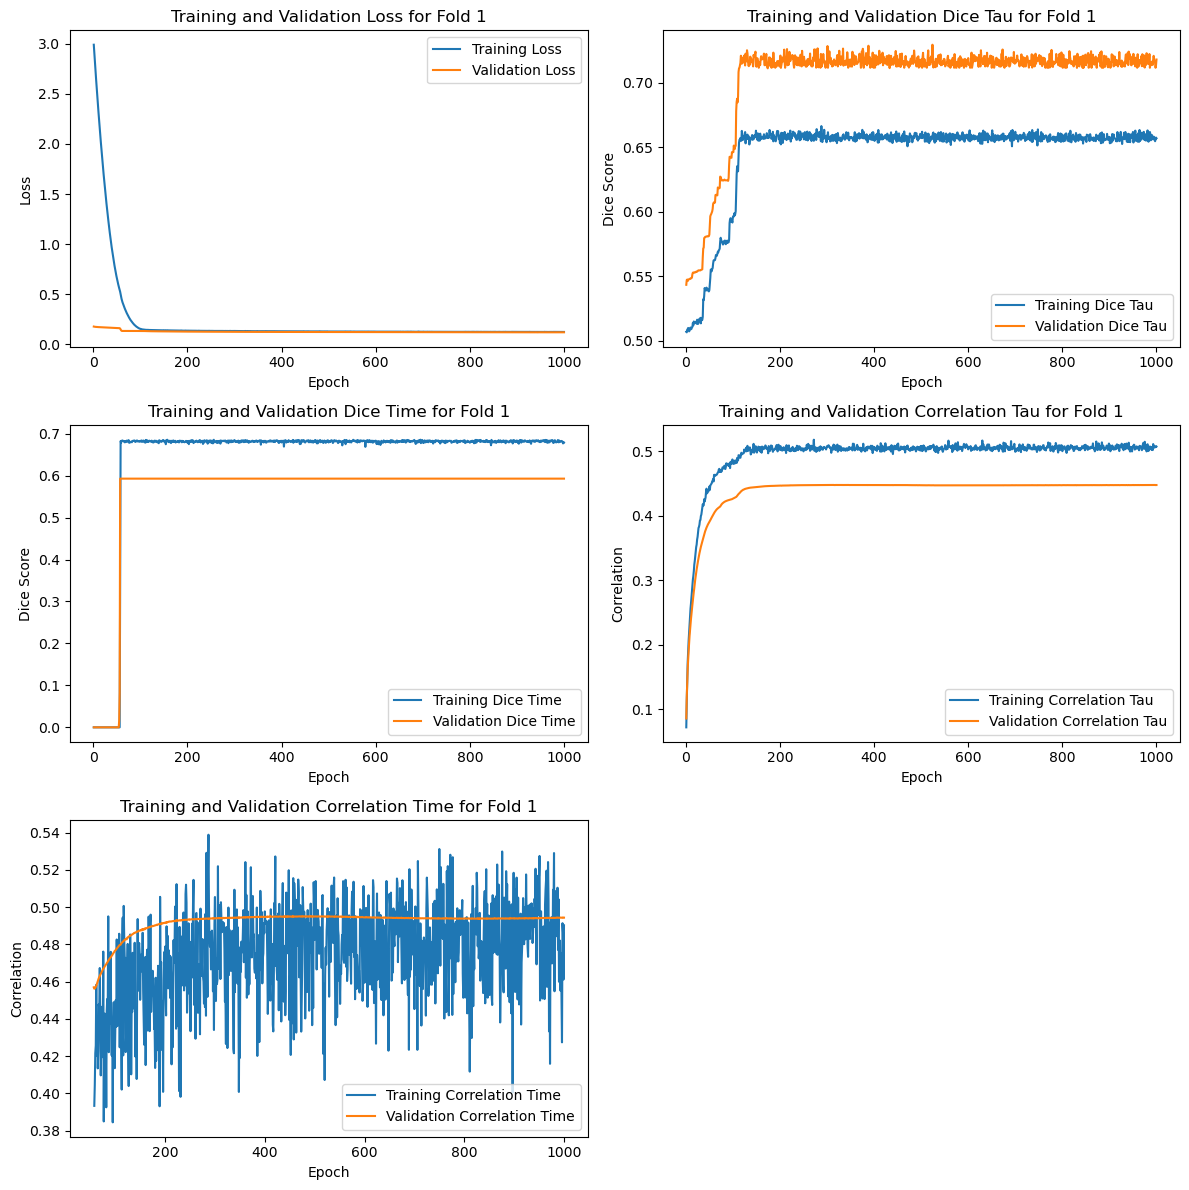

Running fold 2/3


 10%|█         | 101/1000 [00:09<01:13, 12.17it/s]

Epoch 99: Train Loss: 0.1842701109972867, Val Loss: 0.15890195220708847, Train Dice Tau: 0.6290744326331399, Val Dice Tau: 0.619993249575297, Train Dice Time: 6.727767181741677e-10, Val Dice Time: 7.73148147355703e-10, Train Corr Tau: 0.4021277124217427, Val Corr Tau: 0.41326735455273017, Train Corr Time: nan, Val Corr Time: nan


 20%|██        | 201/1000 [00:18<00:56, 14.17it/s]

Epoch 199: Train Loss: 0.13812363012270493, Val Loss: 0.11531587565938632, Train Dice Tau: 0.6754360849207098, Val Dice Tau: 0.6618663370609283, Train Dice Time: 0.64765418659557, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.47938758239723145, Val Corr Tau: 0.4927369082179281, Train Corr Time: 0.5108650973046512, Val Corr Time: 0.5049928363424298


 30%|███       | 301/1000 [00:26<00:55, 12.65it/s]

Epoch 299: Train Loss: 0.13533366403796457, Val Loss: 0.11295301094651222, Train Dice Tau: 0.6768950657411055, Val Dice Tau: 0.6630832751592001, Train Dice Time: 0.6397926861589606, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.48592334061603304, Val Corr Tau: 0.49477292116110355, Train Corr Time: 0.4985844677295384, Val Corr Time: 0.5167733397135331


 40%|████      | 401/1000 [00:34<00:47, 12.49it/s]

Epoch 399: Train Loss: 0.1333718326958743, Val Loss: 0.11134986703594525, Train Dice Tau: 0.6785483468662609, Val Dice Tau: 0.6618663370609283, Train Dice Time: 0.6481643590060148, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.4840806866561161, Val Corr Tau: 0.49470015976416776, Train Corr Time: 0.49550872441876553, Val Corr Time: 0.5219295788696172


 50%|█████     | 500/1000 [00:42<00:41, 12.17it/s]

Epoch 499: Train Loss: 0.13139042190530084, Val Loss: 0.10986492534478505, Train Dice Tau: 0.677822774106806, Val Dice Tau: 0.6742759545644125, Train Dice Time: 0.6485223607583479, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.4885202770866805, Val Corr Tau: 0.49456233841619185, Train Corr Time: 0.4942337039195573, Val Corr Time: 0.5247739480781121


 60%|██████    | 602/1000 [00:51<00:26, 15.26it/s]

Epoch 599: Train Loss: 0.12932895801284097, Val Loss: 0.10865479335188866, Train Dice Tau: 0.6734339378096841, Val Dice Tau: 0.6654588083426157, Train Dice Time: 0.6458984396674416, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.48538618408480544, Val Corr Tau: 0.49453310221459684, Train Corr Time: 0.4469070581868071, Val Corr Time: 0.5267180401761045


 70%|██████▉   | 699/1000 [01:01<00:58,  5.16it/s]

Epoch 699: Train Loss: 0.1277651536193761, Val Loss: 0.10762788355350494, Train Dice Tau: 0.6772956360470165, Val Dice Tau: 0.6619733075300852, Train Dice Time: 0.6415514675053683, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.48612565985713546, Val Corr Tau: 0.494246661319977, Train Corr Time: 0.47397046219641426, Val Corr Time: 0.5285390635607596


 80%|████████  | 801/1000 [01:13<00:18, 10.66it/s]

Epoch 799: Train Loss: 0.12683956866914575, Val Loss: 0.1067792313794295, Train Dice Tau: 0.6751757914369757, Val Dice Tau: 0.6651399830977122, Train Dice Time: 0.6464743451638655, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.483784410526472, Val Corr Tau: 0.49427209086785345, Train Corr Time: 0.5063157946874305, Val Corr Time: 0.530248178172449


 90%|█████████ | 901/1000 [01:26<00:10,  9.79it/s]

Epoch 899: Train Loss: 0.126605556092479, Val Loss: 0.10621014734109242, Train Dice Tau: 0.6764321706511758, Val Dice Tau: 0.6618663370609283, Train Dice Time: 0.6476581692695618, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.48263653018657204, Val Corr Tau: 0.49426122727430566, Train Corr Time: 0.5107650266148391, Val Corr Time: 0.5319536318231332


100%|██████████| 1000/1000 [01:37<00:00, 10.26it/s]


Epoch 999: Train Loss: 0.1250492591749538, Val Loss: 0.10575435062249501, Train Dice Tau: 0.6766090609810569, Val Dice Tau: 0.6618663370609283, Train Dice Time: 0.6464600129560991, Val Dice Time: 0.6768103440602621, Train Corr Tau: 0.4834830507121351, Val Corr Tau: 0.4942988258243846, Train Corr Time: 0.44376612839174095, Val Corr Time: 0.5335611473241177


 14%|█▍        | 141/1000 [00:00<00:03, 265.45it/s]

Epoch 99: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 24%|██▎       | 235/1000 [00:00<00:02, 275.52it/s]

Epoch 199: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 35%|███▍      | 348/1000 [00:01<00:02, 270.69it/s]

Epoch 299: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 44%|████▎     | 436/1000 [00:01<00:02, 276.72it/s]

Epoch 399: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 52%|█████▏    | 522/1000 [00:01<00:01, 259.93it/s]

Epoch 499: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 64%|██████▍   | 645/1000 [00:02<00:01, 273.55it/s]

Epoch 599: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 73%|███████▎  | 727/1000 [00:02<00:01, 250.66it/s]

Epoch 699: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 85%|████████▌ | 852/1000 [00:03<00:00, 299.66it/s]

Epoch 799: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


 94%|█████████▍| 938/1000 [00:03<00:00, 239.64it/s]

Epoch 899: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


100%|██████████| 1000/1000 [00:03<00:00, 263.90it/s]


Epoch 999: Test Loss: 0.09346851408481598, Test Dice Tau: 0.6393980503082275, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5491389364273387, Test Corr Time: 0.5142816148010575


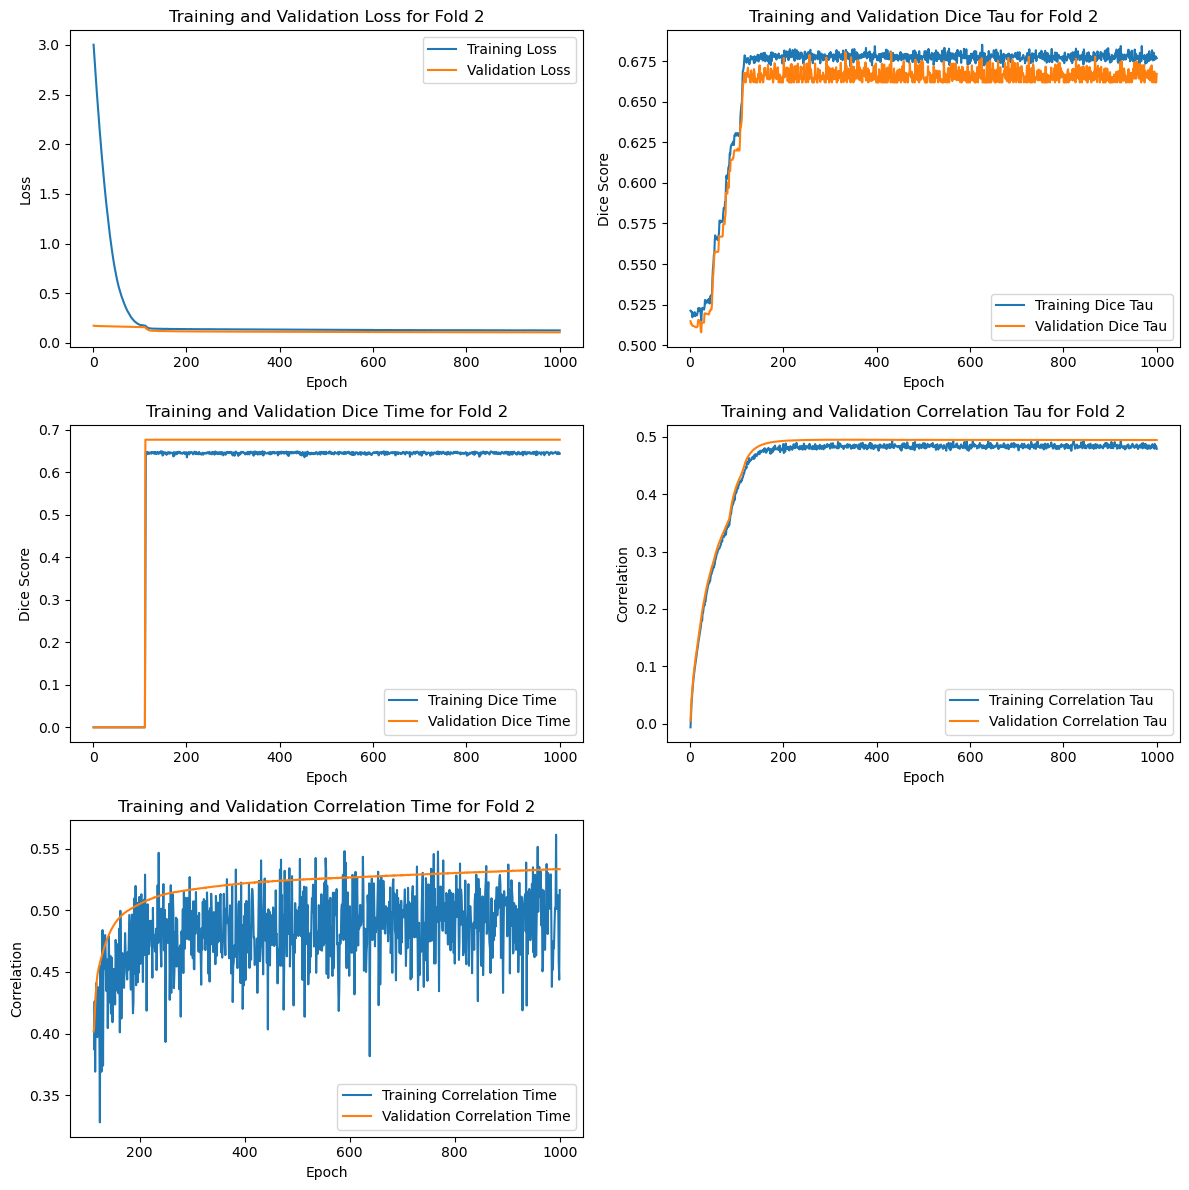

Running fold 3/3


 10%|█         | 100/1000 [00:09<01:17, 11.56it/s]

Epoch 99: Train Loss: 0.1901086704297499, Val Loss: 0.11398588493466377, Train Dice Tau: 0.611816102808172, Val Dice Tau: 0.5945046444733938, Train Dice Time: 0.6427154242992401, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4430313682244392, Val Corr Tau: 0.4571477873838931, Train Corr Time: 0.4319238061879711, Val Corr Time: 0.42997329631008957


 20%|██        | 200/1000 [00:20<00:58, 13.74it/s]

Epoch 199: Train Loss: 0.14565614610910416, Val Loss: 0.10777684673666954, Train Dice Tau: 0.688054231080142, Val Dice Tau: 0.6590682367483774, Train Dice Time: 0.6487275903875177, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4795900612608904, Val Corr Tau: 0.48585623307658365, Train Corr Time: 0.4740788030132928, Val Corr Time: 0.4516254510949231


 30%|███       | 302/1000 [00:29<00:50, 13.96it/s]

Epoch 299: Train Loss: 0.13877513869242233, Val Loss: 0.10616501917441686, Train Dice Tau: 0.6887350082397461, Val Dice Tau: 0.664040187994639, Train Dice Time: 0.6491437283429232, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4824657616939478, Val Corr Tau: 0.48614736153008314, Train Corr Time: 0.40576546225684224, Val Corr Time: 0.46038802750028496


 40%|████      | 400/1000 [00:36<00:42, 14.15it/s]

Epoch 399: Train Loss: 0.13512141392989593, Val Loss: 0.10503033176064491, Train Dice Tau: 0.6885008920322765, Val Dice Tau: 0.6590645511945089, Train Dice Time: 0.6464872089299288, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.48064474293933085, Val Corr Tau: 0.48606385780487615, Train Corr Time: 0.4788534078246354, Val Corr Time: 0.4655652942246585


 50%|█████     | 502/1000 [00:45<00:35, 13.88it/s]

Epoch 499: Train Loss: 0.13356171616099097, Val Loss: 0.1040098878244559, Train Dice Tau: 0.6860307184132662, Val Dice Tau: 0.655835340420405, Train Dice Time: 0.6450466730377891, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.47776289592221877, Val Corr Tau: 0.4855890044360016, Train Corr Time: 0.4425423625505779, Val Corr Time: 0.46842247758476246


 60%|██████    | 600/1000 [00:53<00:31, 12.75it/s]

Epoch 599: Train Loss: 0.13216845352541318, Val Loss: 0.1032650296886762, Train Dice Tau: 0.6848050247539174, Val Dice Tau: 0.655835340420405, Train Dice Time: 0.6494801369580355, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4798480306881402, Val Corr Tau: 0.48459706681788073, Train Corr Time: 0.4339926860646951, Val Corr Time: 0.47067338177443635


 70%|███████   | 700/1000 [01:04<00:32,  9.33it/s]

Epoch 699: Train Loss: 0.13058127056468616, Val Loss: 0.10284904266397159, Train Dice Tau: 0.6845235824584961, Val Dice Tau: 0.655835340420405, Train Dice Time: 0.6462308628992601, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4749180981683603, Val Corr Tau: 0.4835867483015604, Train Corr Time: 0.43736626475665685, Val Corr Time: 0.47259039824465754


 80%|████████  | 800/1000 [01:18<00:25,  7.96it/s]

Epoch 799: Train Loss: 0.12885467437180606, Val Loss: 0.10241468002398808, Train Dice Tau: 0.6838717569004406, Val Dice Tau: 0.6541103521982828, Train Dice Time: 0.6457397558472373, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4824158424688608, Val Corr Tau: 0.4826747294527918, Train Corr Time: 0.44253448087928987, Val Corr Time: 0.47385177383390453


 90%|█████████ | 902/1000 [01:27<00:06, 14.40it/s]

Epoch 899: Train Loss: 0.1275676427917047, Val Loss: 0.10238799701134364, Train Dice Tau: 0.6837372996590354, Val Dice Tau: 0.6533561646938324, Train Dice Time: 0.6459974538196217, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4745700616443205, Val Corr Tau: 0.48168736935874584, Train Corr Time: 0.45631257501042977, Val Corr Time: 0.4763334725999922


100%|██████████| 1000/1000 [01:36<00:00, 10.41it/s]


Epoch 999: Train Loss: 0.12713812901215119, Val Loss: 0.10214164853096008, Train Dice Tau: 0.6821928891268644, Val Dice Tau: 0.6533561646938324, Train Dice Time: 0.6484811305999756, Val Dice Time: 0.6686522364616394, Train Corr Tau: 0.4797932077266157, Val Corr Tau: 0.48144886355063116, Train Corr Time: 0.4701541694716795, Val Corr Time: 0.4779373178361553


 14%|█▍        | 141/1000 [00:00<00:02, 287.81it/s]

Epoch 99: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 23%|██▎       | 233/1000 [00:00<00:02, 289.86it/s]

Epoch 199: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 32%|███▏      | 316/1000 [00:01<00:02, 240.34it/s]

Epoch 299: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 45%|████▍     | 447/1000 [00:02<00:02, 202.61it/s]

Epoch 399: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 51%|█████     | 509/1000 [00:02<00:03, 153.38it/s]

Epoch 499: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 64%|██████▎   | 636/1000 [00:02<00:01, 263.70it/s]

Epoch 599: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 74%|███████▎  | 737/1000 [00:03<00:01, 200.28it/s]

Epoch 699: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 83%|████████▎ | 833/1000 [00:03<00:00, 212.20it/s]

Epoch 799: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


 92%|█████████▏| 920/1000 [00:04<00:00, 259.82it/s]

Epoch 899: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


100%|██████████| 1000/1000 [00:04<00:00, 213.39it/s]


Epoch 999: Test Loss: 0.09347664937376976, Test Dice Tau: 0.6358170866966247, Test Dice Time: 0.6964978694915771, Test Corr Tau: 0.5414949360967378, Test Corr Time: 0.4989255022828547


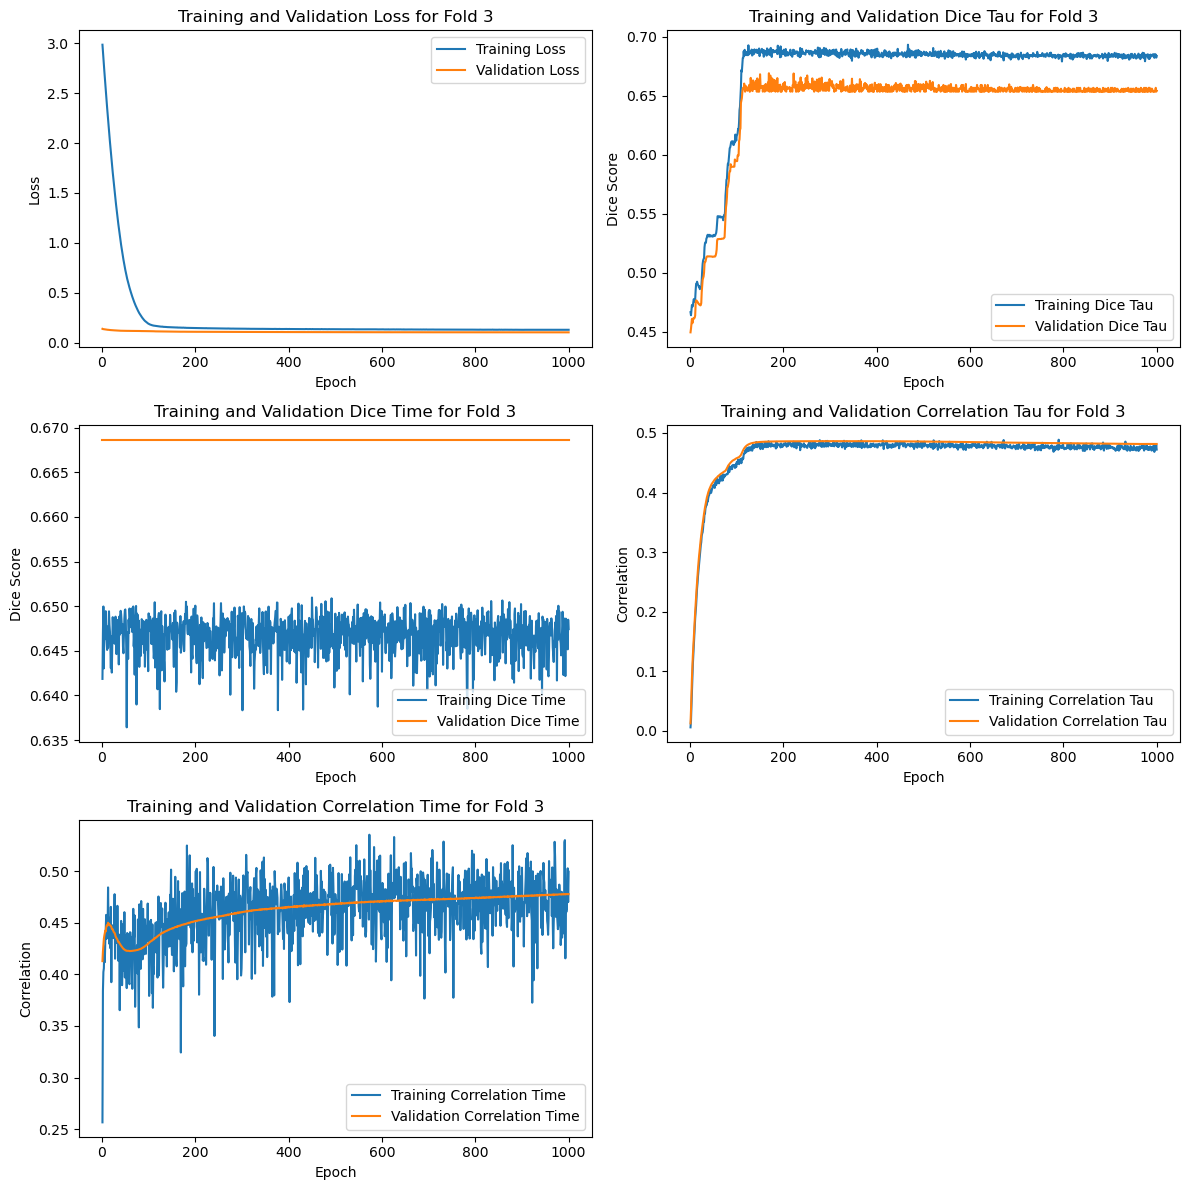

Summary of Test Results across all folds:
Average loss: 0.094
Average dice_tau: 0.639
Average dice_time: 0.696
Average corr_tau: 0.547
Average corr_time: 0.508
Summary of Training Results across all folds:
Average loss: 0.125
Average dice_tau: 0.673
Average dice_time: 0.657
Average corr_tau: 0.486
Average corr_time: 0.502
Summary of Validation Results across all folds:
Average loss: 0.109
Average dice_tau: 0.680
Average dice_time: 0.646
Average corr_tau: 0.475
Average corr_time: 0.502


In [61]:
cross_validator = CrossValidator(TauDNN, Trainer, X_train, y_train_tau, y_train_time, X_test, y_test_tau, y_test_time, 3, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim_tau, output_dim_time, 1000, 32, 'adam',1e-4,1e-3)
cross_validator.execute()

### Extract seeding information 

In [62]:
model = TauDNN(input_dim,hidden1_dim, hidden2_dim, hidden3_dim,
                output_dim_tau, output_dim_time)

In [63]:
# Convert the input features to PyTorch tensors
all_features_tensor = torch.tensor(tau_all, dtype=torch.float32)

In [64]:
# Call the model with the tensors
tau_concentration, time_prediction = model(all_features_tensor)

### Trained Model Predictions 

In [65]:
# Where n_samples is the number of patients or data points and n_regions is the number of brain regions
for sample in range(tau_concentration.shape[0]):  # Iterate through each sample
    print(f'Predicted initial tau concentrations for sample {sample}:')
    for region in range(tau_concentration.shape[1]):  # Iterate through each region
        concentration = tau_concentration[sample, region].item()
        print(f'Region {region}: {concentration}')


Predicted initial tau concentrations for sample 0:
Region 0: 0.0
Region 1: 0.0
Region 2: 0.0
Region 3: 0.0
Region 4: 0.0
Region 5: 0.008941583335399628
Region 6: 0.0
Region 7: 0.0
Region 8: 0.024227164685726166
Region 9: 0.2384321093559265
Region 10: 0.0
Region 11: 0.14658747613430023
Region 12: 0.0
Region 13: 0.02737968973815441
Region 14: 0.14862793684005737
Region 15: 0.19471105933189392
Region 16: 0.038917288184165955
Region 17: 0.0
Region 18: 0.019002385437488556
Region 19: 0.028510645031929016
Region 20: 0.14417912065982819
Region 21: 0.0
Region 22: 0.0
Region 23: 0.0
Region 24: 0.0
Region 25: 0.15216396749019623
Region 26: 0.02016853727400303
Region 27: 0.0
Region 28: 0.0
Region 29: 0.0959196612238884
Region 30: 0.0
Region 31: 0.0
Region 32: 0.0
Region 33: 0.11703405529260635
Region 34: 0.0507412925362587
Region 35: 0.0
Region 36: 0.060727328062057495
Region 37: 0.0
Region 38: 0.0
Region 39: 0.014402244240045547
Region 40: 0.0
Region 41: 0.14701908826828003
Region 42: 0.00699469

In [66]:
# Identify the region with the highest tau concentration for each patient
for i, max_index in enumerate(tau_concentration.argmax(dim=1)):
    max_value = tau_concentration[i, max_index].item()  # Getting the maximum value
    print(f'Patient {i} has highest initial tau concentration in region {max_index.item()}: {max_value}')

Patient 0 has highest initial tau concentration in region 9: 0.2384321093559265
Patient 1 has highest initial tau concentration in region 9: 0.2272217571735382
Patient 2 has highest initial tau concentration in region 9: 0.2390580177307129
Patient 3 has highest initial tau concentration in region 9: 0.23548926413059235
Patient 4 has highest initial tau concentration in region 9: 0.24127554893493652
Patient 5 has highest initial tau concentration in region 9: 0.2304082214832306
Patient 6 has highest initial tau concentration in region 61: 0.23875561356544495
Patient 7 has highest initial tau concentration in region 9: 0.23057548701763153
Patient 8 has highest initial tau concentration in region 9: 0.23039481043815613
Patient 9 has highest initial tau concentration in region 9: 0.23209205269813538
Patient 10 has highest initial tau concentration in region 9: 0.2423374503850937
Patient 11 has highest initial tau concentration in region 9: 0.23715290427207947
Patient 12 has highest initial

In [67]:
# Identify the region with the highest tau concentration overall
for i, max_index in enumerate(tau_concentration.argmax(dim=1)):
    region_name = dictionary_regions[max_index.item()]
    print(f'Patient {i} has the highest initial tau concentration in region: {region_name}')

Patient 0 has the highest initial tau concentration in region: Right-VentralDC
Patient 1 has the highest initial tau concentration in region: Right-VentralDC
Patient 2 has the highest initial tau concentration in region: Right-VentralDC
Patient 3 has the highest initial tau concentration in region: Right-VentralDC
Patient 4 has the highest initial tau concentration in region: Right-VentralDC
Patient 5 has the highest initial tau concentration in region: Right-VentralDC
Patient 6 has the highest initial tau concentration in region: ctx-rh-parahippocampal
Patient 7 has the highest initial tau concentration in region: Right-VentralDC
Patient 8 has the highest initial tau concentration in region: Right-VentralDC
Patient 9 has the highest initial tau concentration in region: Right-VentralDC
Patient 10 has the highest initial tau concentration in region: Right-VentralDC
Patient 11 has the highest initial tau concentration in region: Right-VentralDC
Patient 12 has the highest initial tau conc

In [68]:
# Display the predicted time for each sample
for sample in range(time_prediction.shape[0]):  # Iterate through each sample
    predicted_time = time_prediction[sample].item()  # Extract the predicted time for the sample
    print(f'Predicted time for sample {sample}: {predicted_time}')


Predicted time for sample 0: 0.012879982590675354
Predicted time for sample 1: 0.005854148417711258
Predicted time for sample 2: 0.01389475166797638
Predicted time for sample 3: 0.011168420314788818
Predicted time for sample 4: 0.016922935843467712
Predicted time for sample 5: 0.0
Predicted time for sample 6: 0.020430877804756165
Predicted time for sample 7: 0.006177399307489395
Predicted time for sample 8: 0.008281558752059937
Predicted time for sample 9: 0.006710261106491089
Predicted time for sample 10: 0.014150954782962799
Predicted time for sample 11: 0.011624731123447418
Predicted time for sample 12: 0.008563831448554993
Predicted time for sample 13: 0.0
Predicted time for sample 14: 0.015496484935283661
Predicted time for sample 15: 0.0
Predicted time for sample 16: 0.00469597801566124
Predicted time for sample 17: 0.008509248495101929
Predicted time for sample 18: 0.014927811920642853
Predicted time for sample 19: 0.007062658667564392
Predicted time for sample 20: 0.01649285852